In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

save = True

In [2]:
df_da = pd.DataFrame(data={'date': pd.date_range(start=pd.to_datetime('2014-01-01 00:00'),
                                                    end=pd.to_datetime('31-12-2019 23:00'),
                                                    freq='H')})
df_da['price_da'] = 0
display(df_da.head())
display(df_da.tail())
display(df_da.shape)

,date,price_da
0,2014-01-01 00:00:00,0
1,2014-01-01 01:00:00,0
2,2014-01-01 02:00:00,0
3,2014-01-01 03:00:00,0
4,2014-01-01 04:00:00,0


,date,price_da
52579,2019-12-31 19:00:00,0
52580,2019-12-31 20:00:00,0
52581,2019-12-31 21:00:00,0
52582,2019-12-31 22:00:00,0
52583,2019-12-31 23:00:00,0


(52584, 2)

In [3]:
df_mid_pre = pd.read_csv('./data/tennet/balancedeltaIGCC_history.csv')
df_imb_pre = pd.read_csv('./data/tennet/settlementprices_history.csv')

/home/javier/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
def process_columns_imbalance(dt):
    # Change dates
    dt['date'] = dt.apply(lambda row: pd.to_datetime(f'{row["Date"]} {row["period_until"]}',
                                                        format='%m/%d/%Y %H:%M'), axis=1)
    dt.rename(columns={'Consume': 'price_imbalance', 'Regulation state': 'regulation_state'},
              inplace=True)
    print("Process imbalance")
    display(dt.describe())
    return dt
def process_columns_mid(dt):
    dt['date'] = dt.apply(lambda row: pd.to_datetime(f'{row["Date"]} {row["Time"]}',
                                                        format='%m/%d/%Y %H:%M'), axis=1)
    dt['date'] = dt['date'].dt.round('15min')
    dt.rename(columns={'Mid_price_upward': 'mid_price'}, inplace=True)
    dt = dt.drop_duplicates(subset='date')
    print("Process mid")
    display(dt.describe())
    return dt
def process_dt(dt_da, dt_imbalance, dt_midprice):
    
    #quarter_hours = pd.DataFrame(data={'minutes': [0, 15, 30, 45], 'key': 1})
    quarter_hours = pd.DataFrame(data={'minutes': [0], 'key': 1})
    
    # Get quarter hour
    dt_da['key'] = 1
    dt = pd.merge(dt_da[['date', 'price_da', 'key']], quarter_hours, on='key')
    dt['date'] = dt.apply(lambda row: row['date'].replace(minute=row['minutes']), axis=1)

    # Get imbalance prices
    dt = pd.merge(dt, dt_imbalance[['date', 'price_imbalance', 'regulation_state']], on='date')
    dt = pd.merge(dt, dt_midprice[['date', 'mid_price']], on='date', how='left')
    dt['price_imbalance'] = np.where(dt['regulation_state'] == 2, dt['mid_price'], dt['price_imbalance'])

    # Add hour of the day and day of the year
    dt['hour'] = dt.date.dt.hour
    dt['day_year'] = dt.date.dt.dayofyear

    #dt.drop(columns=['date', 'mid_price', 'regulation_state', 'key'], inplace=True)
    dt.drop(columns=['mid_price', 'regulation_state', 'key'], inplace=True)

    return dt

In [5]:
df_mid = process_columns_mid(df_mid_pre)
df_imb = process_columns_imbalance(df_imb_pre)
df_processed = process_dt(df_da, df_imb, df_mid)    
df_processed["price_imbalance"] = df_processed["price_imbalance"] / 100
display(df_processed.head())
display(df_processed.describe())

Process mid


,Sequence_number,IGCCContribution_up,IGCCContribution_down,To regulate up,To regulate down,To regulate up_reserve,To regulate down_reserve,Emergency capacity,Highest_price_upward,mid_price,Lowest_price_downward
count,210319.000000,210274.000000,210274.000000,210274.000000,210274.000000,210274.000000,210274.000000,210319.000000,86673.000000,210274.000000,89382.000000
mean,721.544487,23.971865,40.231769,30.239806,27.900468,0.140336,0.048437,0.002839,59.921930,34.208506,23.295050
std,415.678887,59.237836,80.096961,62.875055,57.085864,2.673084,2.166466,0.053202,57.693514,7.748035,28.004896
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-31.070000,-500.000000
25%,369.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.110000,29.130000,21.700000
50%,729.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.700000,33.930000,28.410000
75%,1089.000000,10.000000,44.000000,27.000000,26.000000,0.000000,0.000000,0.000000,55.130000,38.610000,34.030000
max,1494.000000,560.000000,770.000000,615.000000,592.000000,180.000000,225.000000,1.000000,936.120000,145.000000,179.010000


Process imbalance


,PTE,To regulate up,To regulate down,Incentive component,price_imbalance,Feed,regulation_state
count,210336.000000,115664.000000,120435.000000,210336.000000,210336.000000,210336.000000,210336.000000
mean,48.500456,69.902237,16.866266,0.035144,43.585220,39.839638,0.136296
std,27.712166,68.533063,36.525418,0.268789,59.440787,57.332039,1.068604
min,1.000000,0.000000,-500.000000,0.000000,-500.000000,-500.000000,-1.000000
25%,24.750000,35.780000,18.500000,0.000000,25.820000,24.690000,-1.000000
50%,48.500000,45.360000,26.210000,0.000000,34.175000,32.710000,0.000000
75%,72.250000,63.530000,32.520000,0.000000,45.890000,43.390000,1.000000
max,100.000000,936.120000,179.010000,3.000000,936.120000,936.120000,2.000000


,date,price_da,minutes,price_imbalance,hour,day_year
0,2014-01-01 00:00:00,0,0,-0.0715,0,1
1,2014-01-01 01:00:00,0,0,-0.4301,1,1
2,2014-01-01 02:00:00,0,0,-1.0001,2,1
3,2014-01-01 03:00:00,0,0,-1.0001,3,1
4,2014-01-01 04:00:00,0,0,-0.6401,4,1


,price_da,minutes,price_imbalance,hour,day_year
count,52584.0,52584.0,52584.000000,52584.000000,52584.000000
mean,0.0,0.0,0.401672,11.500000,183.107885
std,0.0,0.0,0.548857,6.922252,105.417974
min,0.0,0.0,-4.351000,0.000000,1.000000
25%,0.0,0.0,0.249400,5.750000,92.000000
50%,0.0,0.0,0.330700,11.500000,183.000000
75%,0.0,0.0,0.433900,17.250000,274.000000
max,0.0,0.0,9.361200,23.000000,366.000000


In [6]:
df_processed.tail()

,date,price_da,minutes,price_imbalance,hour,day_year
52579,2019-12-31 19:00:00,0,0,0.2334,19,365
52580,2019-12-31 20:00:00,0,0,0.2206,20,365
52581,2019-12-31 21:00:00,0,0,0.0065,21,365
52582,2019-12-31 22:00:00,0,0,0.0680,22,365
52583,2019-12-31 23:00:00,0,0,0.2606,23,365


In [7]:
df_processed[df_processed["date"].dt.year == 2019].describe()

,price_da,minutes,price_imbalance,hour,day_year
count,8760.0,8760.0,8760.000000,8760.000000,8760.000000
mean,0.0,0.0,0.409756,11.500000,183.023973
std,0.0,0.0,0.519201,6.922582,105.374771
min,0.0,0.0,-2.399000,0.000000,1.000000
25%,0.0,0.0,0.244000,5.750000,92.000000
50%,0.0,0.0,0.309800,11.500000,183.000000
75%,0.0,0.0,0.412250,17.250000,274.000000
max,0.0,0.0,9.361200,23.000000,365.000000


In [8]:
if save:
    df_price_2014_2019 = df_processed.drop(columns = ["minutes", "hour", "day_year"])
    df_price_2014_2019.to_csv("./data/df_price_2014_2019.csv", index=False)

In [14]:
display(df_processed[df_processed["date"].dt.year == 2019].describe())
if save:
    df_price_2019 = df_processed[df_processed["date"].dt.year == 2019]
    df_price_2019.to_csv("./data/df_price_2019.csv", index=False)

,price_da,minutes,price_imbalance,hour,day_year
count,8760.0,8760.0,8760.000000,8760.000000,8760.000000
mean,0.0,0.0,0.409756,11.500000,183.023973
std,0.0,0.0,0.519201,6.922582,105.374771
min,0.0,0.0,-2.399000,0.000000,1.000000
25%,0.0,0.0,0.244000,5.750000,92.000000
50%,0.0,0.0,0.309800,11.500000,183.000000
75%,0.0,0.0,0.412250,17.250000,274.000000
max,0.0,0.0,9.361200,23.000000,365.000000


In [9]:
df_dummy = pd.DataFrame(data={'date': pd.date_range(start=pd.to_datetime('01-01-2019 00:00'),
                                                    end=pd.to_datetime('31-12-2019 23:00'),
                                                    freq='H')})
df_dummy['price_imbalance'] = 0.40
display(df_dummy.head())
display(df_dummy.tail())
display(df_dummy.shape)

,date,price_imbalance
0,2019-01-01 00:00:00,0.4
1,2019-01-01 01:00:00,0.4
2,2019-01-01 02:00:00,0.4
3,2019-01-01 03:00:00,0.4
4,2019-01-01 04:00:00,0.4


,date,price_imbalance
8755,2019-12-31 19:00:00,0.4
8756,2019-12-31 20:00:00,0.4
8757,2019-12-31 21:00:00,0.4
8758,2019-12-31 22:00:00,0.4
8759,2019-12-31 23:00:00,0.4


(8760, 2)

In [12]:
df_dummy.describe()

,price_imbalance
count,8.760000e+03
mean,4.000000e-01
std,5.551432e-17
min,4.000000e-01
25%,4.000000e-01
50%,4.000000e-01
75%,4.000000e-01
max,4.000000e-01


In [ ]:
if save:
    df_dummy.to_csv("./data/df_dummy_imbalance_2019.csv", index=False)

In [11]:
!source ~/Scripts/beep.sh

## EDA

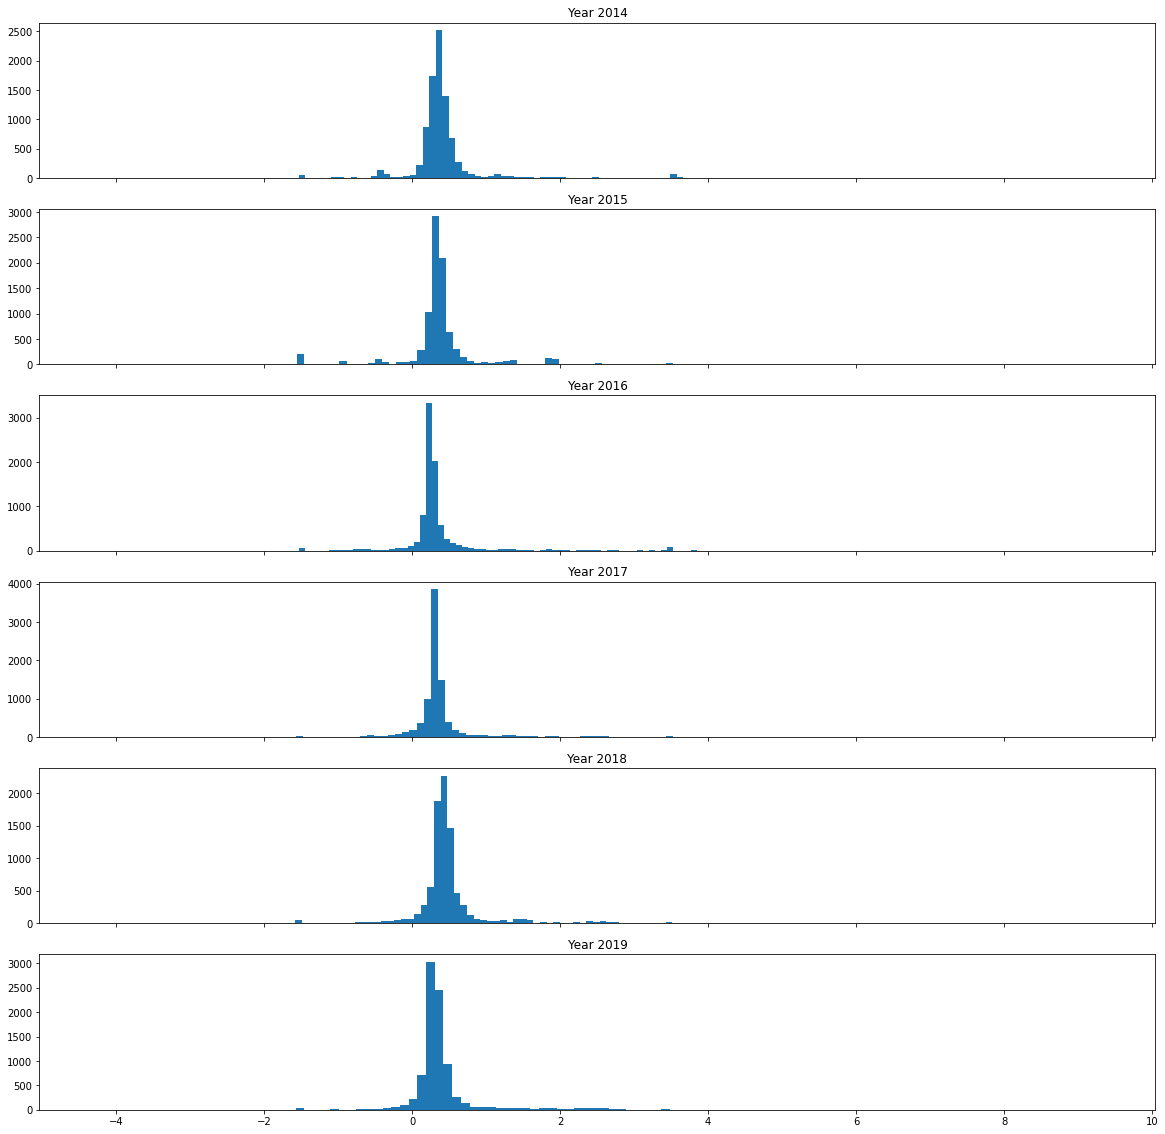

In [10]:
years = [2014, 2015, 2016, 2017, 2018, 2019]

fig1 = plt.figure(figsize =(20,20))
axs = fig1.subplots(6,1, sharex=True)

for i, year in enumerate(years):
    df_year = df_price_2014_2019[df_price_2014_2019["date"].dt.year == year]
    axs[i].hist(df_year["price_imbalance"], bins=100)
    axs[i].set_title(f"Year {year}")    
